In [45]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


import torchvision.transforms.functional as TF

## - Import

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.5.1+cu118
device: cuda


## - Parameters

In [12]:
# Data
train_data_path = './FashionMnist/mario_test.csv' # Path of data
valid_data_path = './FashionMnist/fashion-mnist_test.csv' # Path of data
print('Train data path:', train_data_path)
print('Valid data path:', valid_data_path)

img_size = 14 # Image size
batch_size = 32  # Batch size

# Model
z_size = 9
# generator_layer_size = [64, 128, 256]
# discriminator_layer_size = [256, 128, 64]
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 1000  # Train epochs
Discriminatorlearning_rate = 1e-4
Generatorlearning_rate = 1e-4

# Save parameters
SaveEachEpochs = 100
SaveModelName = "TestSagan"
ShouldLoadModel = False

# Show
# ShowSampleEachEpochs = 10
ShowSampleEachEpochs = SaveEachEpochs


Train data path: ./FashionMnist/mario_test.csv
Valid data path: ./FashionMnist/fashion-mnist_test.csv


## - Pytorch Dataset, DataLoader: Fashion MNIST

In [14]:
class_list = ['Normal', 'Subterraneo', 'Hills']
class_num = len(class_list)

In [16]:
class FashionMNIST(Dataset):
    def __init__(self, path, img_size, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv(path)
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, img_size, img_size)
        self.labels = fashion_df.label.values
        print('Image size:', self.images.shape)
        print('--- Label ---')
        print(fashion_df.label.value_counts())

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = self.images[idx]
        img = Image.fromarray(self.images[idx])
            
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [18]:
dataset = FashionMNIST(train_data_path, img_size)

Image size: (2698, 14, 14)
--- Label ---
label
0    1829
2     554
1     315
Name: count, dtype: int64


In [20]:
dataset[1][0]

In [22]:
class_list[dataset[1][1]]

'Normal'

In [24]:
dataset[2][0]

In [26]:
class_list[dataset[0][1]]

'Normal'

In [28]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

In [30]:
dataset = FashionMNIST(train_data_path, img_size, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

Image size: (2698, 14, 14)
--- Label ---
label
0    1829
2     554
1     315
Name: count, dtype: int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


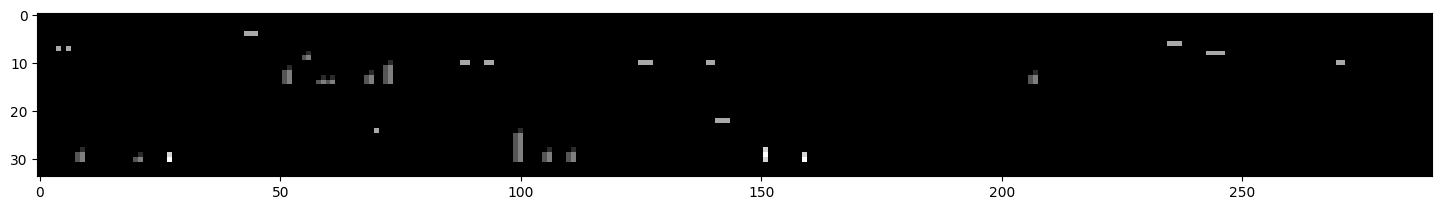

In [32]:
for images, labels in data_loader:
    fig, ax = plt.subplots(figsize=(18,3))
    ax.imshow(make_grid(images, nrow=18).permute(1,2,0))
    break

In [34]:
## SAGAN MODULE
class GeneratorSNBlock(nn.Module):
    # A generator block to upsample the input by a factor of 2
    def __init__(self, in_channels, out_channels):
        super(GeneratorSNBlock, self).__init__()
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")

        self.conv_module = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

        self.residual_conv = spectral_norm(nn.Conv2d(in_channels, out_channels, 1, 1))

    def forward(self, x):
        identity = x

        # Upsample and SN Conv
        x = self.upsample(x)
        x = self.conv_module(x)

        # Residual connection
        return x + self.residual_conv(self.upsample(identity))


## - Generator

In [36]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        
        self.z_size = z_size
        self.img_size = img_size
        
        self.label_emb = nn.Embedding(class_num, class_num)
        
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        
        # Reshape z
        z = z.view(-1, self.z_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([z, c], 1)
        
        # Generator out
        out = self.model(x)
        
        return out.view(-1, self.img_size, self.img_size)

## - Discriminator

In [37]:
class DiscriminatorSNBlock(nn.Module):
    # A generator block to upsample the input by a factor of 2
    def __init__(self, in_channels, out_channels):
        super(DiscriminatorSNBlock, self).__init__()
        self.relu = nn.ReLU()
        self.downsample = nn.AvgPool2d(2)

        self.conv_module = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, out_channels, 3, 1, padding=1)),
            nn.ReLU(),
            spectral_norm(nn.Conv2d(out_channels, out_channels, 3, 1, padding=1)),
            nn.ReLU(),
        )

        self.residual_conv = spectral_norm(nn.Conv2d(in_channels, out_channels, 1, 1))

    def forward(self, x):
        identity = x

        # SN Conv and Downsample
        x = self.conv_module(x)
        x = self.downsample(x)

        # Residual connection
        return x + self.residual_conv(self.downsample(identity))

In [38]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        
        # Reshape fake image
        x = x.view(-1, self.img_size * self.img_size)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [39]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

## - Adversarial Learning of Generator & Discriminator

In [40]:
# Loss function
criterion = nn.BCELoss()

In [41]:
# Optimizer
g_optimizer = torch.optim.Adam(generator.parameters(), lr=Generatorlearning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=Discriminatorlearning_rate)

In [42]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [22]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

Starting epoch 1...
g_loss: 1.2747461795806885, d_loss: 0.7637763023376465
Starting epoch 2...
g_loss: 3.018360137939453, d_loss: 0.25522932410240173
Starting epoch 3...
g_loss: 1.530853271484375, d_loss: 1.9165465831756592
Starting epoch 4...
g_loss: 3.4159250259399414, d_loss: 0.48772042989730835
Starting epoch 5...
g_loss: 1.0994586944580078, d_loss: 0.9488274455070496
Starting epoch 6...
g_loss: 1.3932194709777832, d_loss: 1.2346529960632324
Starting epoch 7...
g_loss: 2.2501392364501953, d_loss: 0.5853813290596008
Starting epoch 8...
g_loss: 1.2356176376342773, d_loss: 1.9908466339111328
Starting epoch 9...
g_loss: 1.2709550857543945, d_loss: 1.123453974723816
Starting epoch 10...
g_loss: 0.7497586607933044, d_loss: 1.7682933807373047
Starting epoch 11...
g_loss: 1.555593490600586, d_loss: 1.0938283205032349
Starting epoch 12...
g_loss: 0.956447184085846, d_loss: 1.0227711200714111
Starting epoch 13...
g_loss: 1.242652177810669, d_loss: 0.9817919731140137
Starting epoch 14...
g_lo

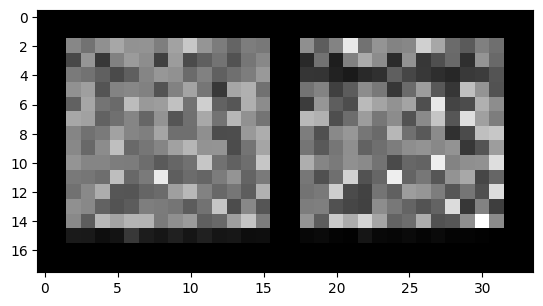

Starting epoch 101...
g_loss: 1.1045877933502197, d_loss: 0.8525826930999756
Starting epoch 102...
g_loss: 1.156346082687378, d_loss: 1.0404685735702515
Starting epoch 103...
g_loss: 1.1534640789031982, d_loss: 1.0906366109848022
Starting epoch 104...
g_loss: 0.9811195731163025, d_loss: 1.316239833831787
Starting epoch 105...
g_loss: 0.6141320466995239, d_loss: 1.2033467292785645
Starting epoch 106...
g_loss: 1.4349887371063232, d_loss: 1.0925061702728271
Starting epoch 107...
g_loss: 0.9391354322433472, d_loss: 1.0734230279922485
Starting epoch 108...
g_loss: 1.4123704433441162, d_loss: 1.8447952270507812
Starting epoch 109...
g_loss: 1.015531063079834, d_loss: 0.9870789647102356
Starting epoch 110...
g_loss: 0.9909241199493408, d_loss: 1.267479658126831
Starting epoch 111...
g_loss: 0.9510099291801453, d_loss: 1.1133389472961426
Starting epoch 112...
g_loss: 0.9279764890670776, d_loss: 1.5055744647979736
Starting epoch 113...
g_loss: 1.1481385231018066, d_loss: 1.2654746770858765
Sta

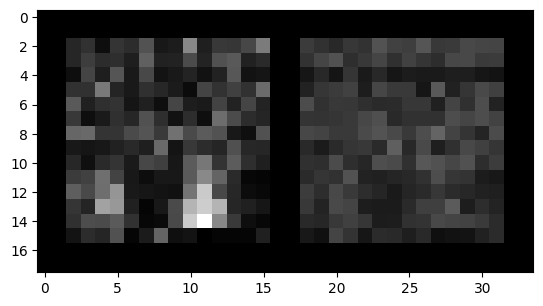

Starting epoch 201...
g_loss: 0.9737465977668762, d_loss: 1.1626802682876587
Starting epoch 202...
g_loss: 1.1480605602264404, d_loss: 1.0486500263214111
Starting epoch 203...
g_loss: 1.0874837636947632, d_loss: 0.8504738807678223
Starting epoch 204...
g_loss: 0.7943997979164124, d_loss: 1.2585445642471313
Starting epoch 205...
g_loss: 0.8706556558609009, d_loss: 1.291814923286438
Starting epoch 206...
g_loss: 0.7973065376281738, d_loss: 1.3555930852890015
Starting epoch 207...
g_loss: 0.7998007535934448, d_loss: 1.3760966062545776
Starting epoch 208...
g_loss: 1.0312178134918213, d_loss: 1.151827096939087
Starting epoch 209...
g_loss: 0.6372382640838623, d_loss: 1.0954480171203613
Starting epoch 210...
g_loss: 0.8952966332435608, d_loss: 1.222881555557251
Starting epoch 211...
g_loss: 0.8827380537986755, d_loss: 1.4342172145843506
Starting epoch 212...
g_loss: 1.1054401397705078, d_loss: 1.1203938722610474
Starting epoch 213...
g_loss: 0.9306640028953552, d_loss: 1.4383915662765503
St

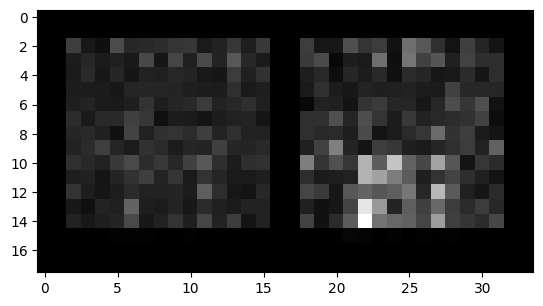

Starting epoch 301...
g_loss: 0.8489093780517578, d_loss: 1.556145429611206
Starting epoch 302...
g_loss: 1.6359572410583496, d_loss: 0.9199392795562744
Starting epoch 303...
g_loss: 1.0028436183929443, d_loss: 1.4054548740386963
Starting epoch 304...
g_loss: 1.2362186908721924, d_loss: 1.1468181610107422
Starting epoch 305...
g_loss: 0.9099556803703308, d_loss: 1.2016823291778564
Starting epoch 306...
g_loss: 0.9644486904144287, d_loss: 1.286907434463501
Starting epoch 307...
g_loss: 1.067502737045288, d_loss: 1.4799764156341553
Starting epoch 308...
g_loss: 0.8999024629592896, d_loss: 1.3390166759490967
Starting epoch 309...
g_loss: 0.9314209222793579, d_loss: 0.8193472623825073
Starting epoch 310...
g_loss: 1.1442090272903442, d_loss: 1.3504698276519775
Starting epoch 311...
g_loss: 1.0548149347305298, d_loss: 1.0808720588684082
Starting epoch 312...
g_loss: 0.8580363988876343, d_loss: 1.1180473566055298
Starting epoch 313...
g_loss: 1.3710098266601562, d_loss: 1.2878391742706299
St

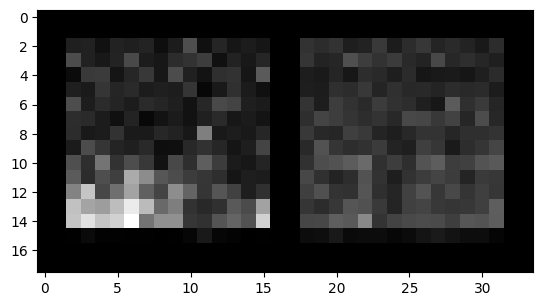

Starting epoch 401...
g_loss: 0.9401103854179382, d_loss: 1.2361388206481934
Starting epoch 402...
g_loss: 1.0479882955551147, d_loss: 1.2047340869903564
Starting epoch 403...
g_loss: 1.0684514045715332, d_loss: 1.1951185464859009
Starting epoch 404...
g_loss: 0.8302068710327148, d_loss: 1.0690253973007202
Starting epoch 405...
g_loss: 0.9818164110183716, d_loss: 1.2110652923583984
Starting epoch 406...
g_loss: 1.0744918584823608, d_loss: 1.2542724609375
Starting epoch 407...
g_loss: 1.00266432762146, d_loss: 1.387113094329834
Starting epoch 408...
g_loss: 0.9071716070175171, d_loss: 1.182732343673706
Starting epoch 409...
g_loss: 0.998332142829895, d_loss: 1.5898014307022095
Starting epoch 410...
g_loss: 1.2951974868774414, d_loss: 1.3102266788482666
Starting epoch 411...
g_loss: 0.9519253373146057, d_loss: 1.3346911668777466
Starting epoch 412...
g_loss: 0.8802332878112793, d_loss: 1.278692364692688
Starting epoch 413...
g_loss: 0.717743992805481, d_loss: 0.9619423747062683
Starting 

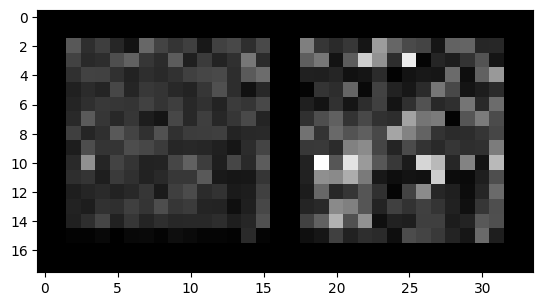

Starting epoch 501...
g_loss: 1.0298826694488525, d_loss: 1.2104520797729492
Starting epoch 502...
g_loss: 0.8296735286712646, d_loss: 1.3022023439407349
Starting epoch 503...
g_loss: 0.8903601169586182, d_loss: 1.1681644916534424
Starting epoch 504...
g_loss: 0.9531821012496948, d_loss: 1.1891486644744873
Starting epoch 505...
g_loss: 0.9413994550704956, d_loss: 1.440066933631897
Starting epoch 506...
g_loss: 0.9087185859680176, d_loss: 1.2710199356079102
Starting epoch 507...
g_loss: 1.13552987575531, d_loss: 1.1767009496688843
Starting epoch 508...
g_loss: 0.7189284563064575, d_loss: 1.4921071529388428
Starting epoch 509...
g_loss: 1.0455090999603271, d_loss: 1.2754120826721191
Starting epoch 510...
g_loss: 0.9749982357025146, d_loss: 1.0012421607971191
Starting epoch 511...
g_loss: 0.8846937417984009, d_loss: 1.2873566150665283
Starting epoch 512...
g_loss: 1.049288034439087, d_loss: 1.0689955949783325
Starting epoch 513...
g_loss: 1.0109074115753174, d_loss: 1.1154478788375854
Sta

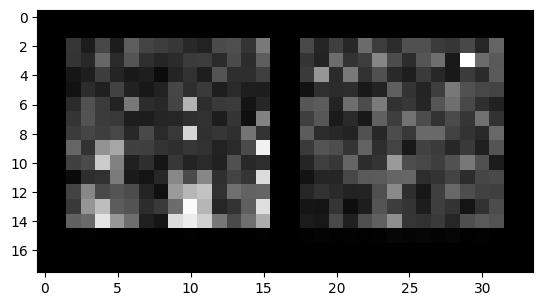

Starting epoch 601...
g_loss: 0.9187874794006348, d_loss: 1.1833927631378174
Starting epoch 602...
g_loss: 0.9770910739898682, d_loss: 1.16058349609375
Starting epoch 603...
g_loss: 1.0374250411987305, d_loss: 0.8443329334259033
Starting epoch 604...
g_loss: 0.6984140872955322, d_loss: 1.2311826944351196
Starting epoch 605...
g_loss: 1.004897117614746, d_loss: 1.1163121461868286
Starting epoch 606...
g_loss: 0.8362393379211426, d_loss: 1.146168828010559
Starting epoch 607...
g_loss: 1.1735773086547852, d_loss: 1.1923465728759766
Starting epoch 608...
g_loss: 1.050816535949707, d_loss: 0.8228145837783813
Starting epoch 609...
g_loss: 0.9604195356369019, d_loss: 1.14987313747406
Starting epoch 610...
g_loss: 0.9705979824066162, d_loss: 1.2374125719070435
Starting epoch 611...
g_loss: 0.9550502300262451, d_loss: 1.2907586097717285
Starting epoch 612...
g_loss: 0.9077962636947632, d_loss: 0.953657865524292
Starting epoch 613...
g_loss: 0.9516369104385376, d_loss: 1.2971301078796387
Startin

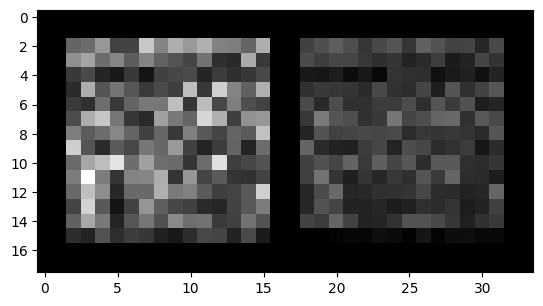

Starting epoch 701...
g_loss: 1.2376461029052734, d_loss: 1.1176410913467407
Starting epoch 702...
g_loss: 1.058906078338623, d_loss: 0.7832719087600708
Starting epoch 703...
g_loss: 1.058262825012207, d_loss: 1.054211139678955
Starting epoch 704...
g_loss: 0.7958797216415405, d_loss: 1.1892013549804688
Starting epoch 705...
g_loss: 0.9697652459144592, d_loss: 1.2695878744125366
Starting epoch 706...
g_loss: 0.9990829229354858, d_loss: 1.1954474449157715
Starting epoch 707...
g_loss: 0.8639854192733765, d_loss: 1.302526593208313
Starting epoch 708...
g_loss: 1.046275019645691, d_loss: 1.4503936767578125
Starting epoch 709...
g_loss: 1.0722556114196777, d_loss: 1.2623708248138428
Starting epoch 710...
g_loss: 0.9609053730964661, d_loss: 1.1640640497207642
Starting epoch 711...
g_loss: 0.9988479614257812, d_loss: 1.0746955871582031
Starting epoch 712...
g_loss: 1.0735374689102173, d_loss: 1.169938325881958
Starting epoch 713...
g_loss: 0.6604959964752197, d_loss: 1.1035135984420776
Start

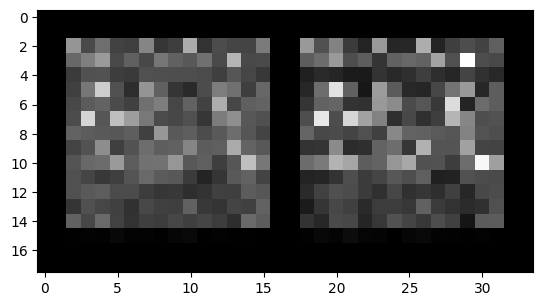

Starting epoch 801...
g_loss: 1.00294029712677, d_loss: 0.8022371530532837
Starting epoch 802...
g_loss: 1.069203495979309, d_loss: 1.2164502143859863
Starting epoch 803...
g_loss: 1.0146758556365967, d_loss: 1.0585530996322632
Starting epoch 804...
g_loss: 1.1179718971252441, d_loss: 1.4802968502044678
Starting epoch 805...
g_loss: 0.9290409684181213, d_loss: 1.2198004722595215
Starting epoch 806...
g_loss: 0.9748719334602356, d_loss: 1.149566411972046
Starting epoch 807...
g_loss: 0.9304118156433105, d_loss: 1.1564733982086182
Starting epoch 808...
g_loss: 1.1123199462890625, d_loss: 1.3838934898376465
Starting epoch 809...
g_loss: 0.8350768089294434, d_loss: 1.437988042831421
Starting epoch 810...
g_loss: 1.0266896486282349, d_loss: 1.0770294666290283
Starting epoch 811...
g_loss: 0.957922637462616, d_loss: 1.6936824321746826
Starting epoch 812...
g_loss: 1.0944244861602783, d_loss: 1.0971698760986328
Starting epoch 813...
g_loss: 0.7170672416687012, d_loss: 1.2337846755981445
Start

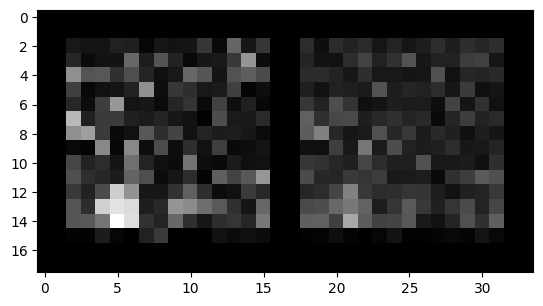

Starting epoch 901...
g_loss: 1.2322163581848145, d_loss: 1.6410374641418457
Starting epoch 902...
g_loss: 0.9691166281700134, d_loss: 1.0414729118347168
Starting epoch 903...
g_loss: 1.0166833400726318, d_loss: 1.1070811748504639
Starting epoch 904...
g_loss: 0.8841548562049866, d_loss: 1.1563999652862549
Starting epoch 905...
g_loss: 0.9050546288490295, d_loss: 1.0967739820480347
Starting epoch 906...
g_loss: 1.348064661026001, d_loss: 0.8378491997718811
Starting epoch 907...
g_loss: 0.637263834476471, d_loss: 1.562885046005249
Starting epoch 908...
g_loss: 1.0054264068603516, d_loss: 1.3135502338409424
Starting epoch 909...
g_loss: 0.9403932094573975, d_loss: 1.2796283960342407
Starting epoch 910...
g_loss: 0.8313156962394714, d_loss: 1.3285037279129028
Starting epoch 911...
g_loss: 0.7668416500091553, d_loss: 1.4574155807495117
Starting epoch 912...
g_loss: 1.1157875061035156, d_loss: 1.2984555959701538
Starting epoch 913...
g_loss: 0.8889544010162354, d_loss: 1.430370569229126
Sta

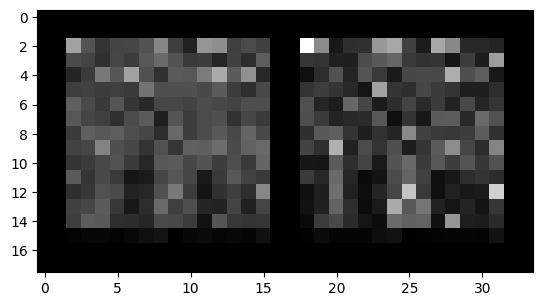

In [23]:
# bIsTraining = False
bIsTraining = True
if bIsTraining:
    for epoch in range(epochs):
        
        print('Starting epoch {}...'.format(epoch+1))
        
        for i, (images, labels) in enumerate(data_loader):
            
            # Train data
            real_images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            # print(real_images[0])
            # print("labels")
            # print(labels[0])
            # brSeak
            # Set generator train
            generator.train()
            
            # Train discriminator
            d_loss = discriminator_train_step(len(real_images), discriminator,
                                              generator, d_optimizer, criterion,
                                              real_images, labels)
            
            # Train generator
            g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
    
        # break
        # Set generator eval
        generator.eval()
        
        print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
        
        # Building z 
        z = Variable(torch.randn(class_num-1, z_size)).to(device)
        
        # Labels 0 ~ 8
        labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
        
        # Generating images
        sample_images = generator(z, labels).unsqueeze(1).data.cpu()
        
        if((epoch + 1) % SaveEachEpochs == 0):
            torch.save(generator.state_dict(),f'Checkpoints/{SaveModelName}Gen{epoch+1}.pth')
            torch.save(generator.state_dict(),f'Checkpoints/{SaveModelName}Dis{epoch+1}.pth')
    
        if((epoch + 1) % ShowSampleEachEpochs == 0):
            # Show images
            grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
            plt.imshow(grid)
            plt.show()

## - Show Generating Images

In [47]:

mapeo_caracteres = {'X': 0, 'S': 1, '-': 2, '?': 3, 'Q': 4, 'E': 5, '<': 6, '>': 7, '[': 8, ']': 9, 'o': 10, 'B': 11, 'b': 12}
mapeo_caracteres_inverso = {valor: clave for clave, valor in mapeo_caracteres.items()}
map_number = len(mapeo_caracteres.keys())

def lerp(a, b, t):
    return a * (1 - t) + b * t
def CloserNumber(list,number):
    return min(list, key=lambda x: abs(x - number))
def Decoder(sample_images):
    print("tensor edit")
    
    for i in range(len(sample_images)):
        rows,cols = sample_images[i][0].shape
        for j in range(rows):
            for k in range(cols):
                sample_images[i][0][j][k] = round(CloserNumber(data_normalized,sample_images[i][0][j][k]),8)
def ConverToTxt(sample_images):
    print("tensor edit")
    
    for i in range(len(sample_images)):
        rows,cols = sample_images[i][0].shape
        for j in range(rows):
            for k in range(cols):
                sample_images[i][0][j][k] = round(CloserNumber(data_normalized,sample_images[i][0][j][k]),8)
# DAta
def convertir_png_a_txt(ruta_imagen, ruta_txt):
    # Abrir la imagen PNG
    imagen = Image.open(ruta_imagen)

    # Obtener dimensiones de la imagen
    ancho, alto = imagen.size

    # Obtener los píxeles de la imagen
    pixeles = imagen.load()

    # Abrir o crear el archivo de texto para escribir
    with open(ruta_txt, 'w') as archivo_txt:
        # Iterar sobre cada píxel y escribir su valor en el archivo de texto
        for y in range(alto):
            for x in range(ancho):
                # Obtener el valor del píxel en formato RGB (tupla)
                valor_pixel =  mapeo_caracteres_inverso[CloserNumber(dataRGBrange,pixeles[x,y])*(map_number-1)/255]
               
                
                # Convertir la tupla de RGB a cadena y escribir en el archivo de texto
                archivo_txt.write(f"{valor_pixel}")

            # Agregar un salto de línea al final de cada fila
            archivo_txt.write("\n")
dataRGBrange = [ i/(map_number-1) * 255 for i in range(map_number)]
data_normalized = [ lerp(0,1,i/(map_number-1)) for i in range(map_number)]
print(dataRGBrange)
print(data_normalized)


[0.0, 21.25, 42.5, 63.75, 85.0, 106.25, 127.5, 148.75, 170.0, 191.25, 212.5, 233.75, 255.0]
[0.0, 0.08333333333333333, 0.16666666666666666, 0.25, 0.3333333333333333, 0.4166666666666667, 0.5, 0.5833333333333334, 0.6666666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 1.0]


tensor([0, 1, 2, 0, 1, 2, 0, 1, 2], device='cuda:0')
Running main from image generator


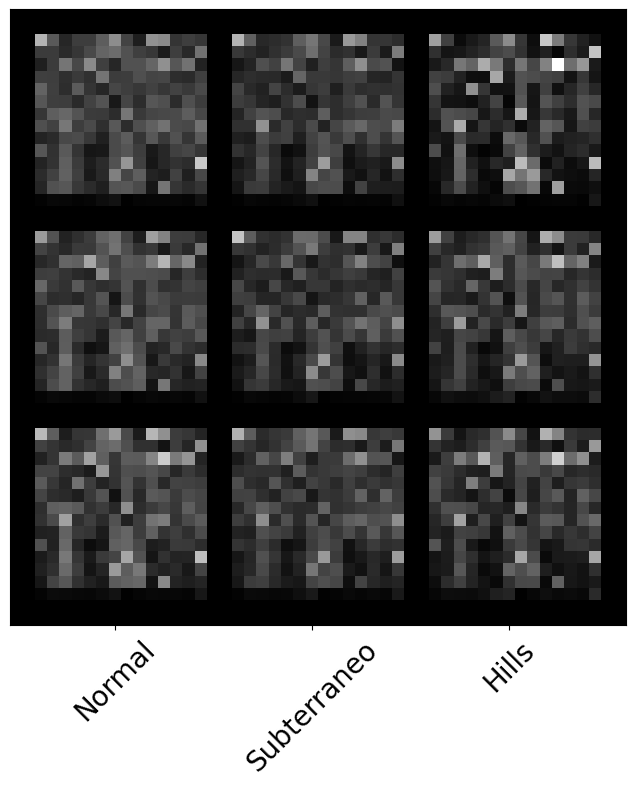

In [34]:



# Building z 
z = Variable(torch.randn(z_size, z_size)).to(device)

    
# Labels 0 ~ 9
testlabels = np.full(z_size, 0)
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)
# labels = Variable(torch.LongTensor([1 for _ in range(class_num) for i in range(class_num)])).to(device)
# labels = Variable(torch.LongTensor(testlabels)).to(device)
print(labels)
# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
# Decoder(sample_images)

## Saving Images
pil_images = [TF.to_pil_image(image) for image in sample_images]
for i, pil_image in enumerate(pil_images):
    pil_image.save(f"imagen_{i}.png")
    convertir_png_a_txt(f"imagen_{i}.png", f"MarioBrosImageRenderer/GeneratedLevels/imagen_{i}.txt")

## Converting images to 
execfile('MarioBrosImageRenderer/gameImageGenerator.py')
# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(8, 6*8, 16), class_list, rotation=45, fontsize=20)

from PIL import Image



In [48]:
fileToLoad = "Checkpoints/Test20000EpochsGen20000.pth"
GeneratorLoader = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
GeneratorLoader.load_state_dict(torch.load(fileToLoad))

z = Variable(torch.randn(z_size, z_size)).to(device)

testlabels = np.full(z_size, 0)
labels = Variable(torch.LongTensor([_ for _ in range(class_num) for i in range(class_num)])).to(device)
print(labels)
sample_images = GeneratorLoader(z, labels).unsqueeze(1).data.cpu()
## Saving Images
pil_images = [TF.to_pil_image(image) for image in sample_images]
for i, pil_image in enumerate(pil_images):
    pil_image.save(f"imagen_{i}.png")
    print(i,pil_image)
    print("next")
    convertir_png_a_txt(f"imagen_{i}.png", f"MarioBrosImageRenderer/GeneratedLevels/imagen_{i}.txt")
execfile('MarioBrosImageRenderer/gameImageGenerator.py')

/tmp/ipykernel_725/3803854696.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  GeneratorLoader.load_state_dict(torch.load(fileToLoad))


tensor([0, 0, 0, 1, 1, 1, 2, 2, 2], device='cuda:0')
0 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436665160>
next
1 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436666FF0>
next
2 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436665A90>
next
3 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436667680>
next
4 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436666EA0>
next
5 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436666BD0>
next
6 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436664CE0>
next
7 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436667E90>
next
8 <PIL.Image.Image image mode=L size=14x14 at 0x7FE436667350>
next
Running main from image generator
